In [10]:
# MONAI and PyTorch: Medical Imaging with Tensors

# Section 1: Introduction
"""
This notebook demonstrates how tensors are used in medical imaging applications with PyTorch and MONAI.
We will walk through data loading, applying transforms, model inference, and visualization.
Updated to use user-provided data (e.g., images loaded with OpenCV or other libraries).
"""

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from monai.transforms import Compose, AddChannel, ScaleIntensity, ToTensor, Resize
from monai.networks.nets import UNet
import SimpleITK as sitk

In [2]:
print(os.getcwd())

d:\test\tensor_notebook


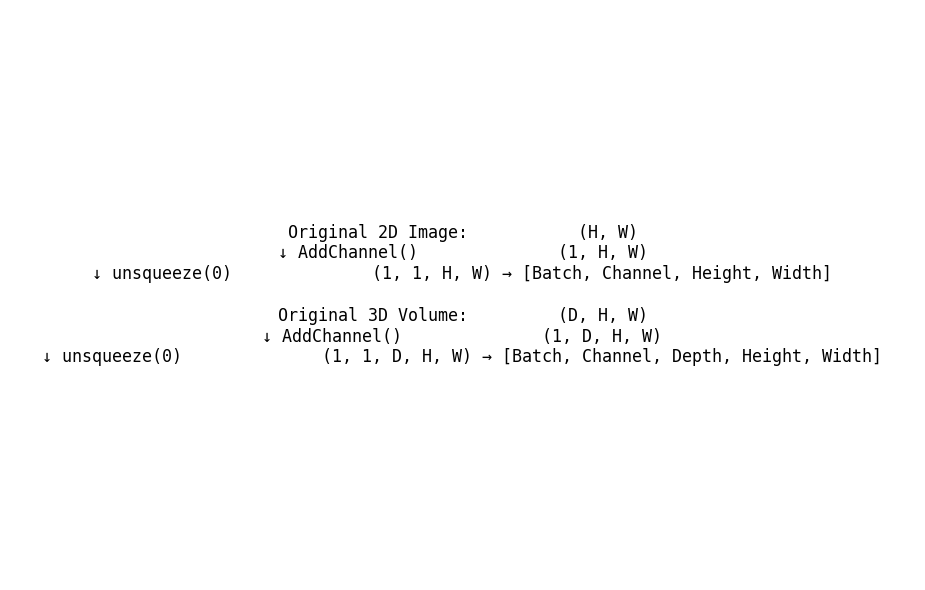

'\nTensors in medical imaging typically have the shape:\n- 2D images: (N, C, H, W)\n- 3D images: (N, C, D, H, W)\nWhere:\nN = Batch size\nC = Number of channels (e.g., 1 for grayscale, 3 for RGB)\nH = Height, W = Width, D = Depth\n'

In [3]:
# Section 2: Understanding Tensor Dimensions

# Visual Diagram of Tensor Dimension Changes
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
diagram_text = """
Original 2D Image:           (H, W)
↓ AddChannel()              (1, H, W)
↓ unsqueeze(0)              (1, 1, H, W) → [Batch, Channel, Height, Width]

Original 3D Volume:         (D, H, W)
↓ AddChannel()              (1, D, H, W)
↓ unsqueeze(0)              (1, 1, D, H, W) → [Batch, Channel, Depth, Height, Width]
"""
ax.axis('off')
ax.text(0.5, 0.5, diagram_text, fontsize=12, ha='center', va='center', family='monospace')
plt.tight_layout()
plt.show()
"""
Tensors in medical imaging typically have the shape:
- 2D images: (N, C, H, W)
- 3D images: (N, C, D, H, W)
Where:
N = Batch size
C = Number of channels (e.g., 1 for grayscale, 3 for RGB)
H = Height, W = Width, D = Depth
"""

In [5]:
# Section 3: Load Your Own 2D and 3D Medical Image Data
"""
Preprocessing Demonstrations:
1. OpenCV-based preprocessing: Resize and Gaussian blur (for 2D images).
2. SimpleITK-based preprocessing: Resample spacing and intensity normalization (for 3D volumes).
"""

def preprocess_2d_opencv(img):
    # Resize to 128x128 and apply Gaussian blur
    resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)
    return blurred.astype(np.float32) / 255.0

def preprocess_3d_sitk(volume_np):
    volume_sitk = sitk.GetImageFromArray(volume_np)
    original_spacing = volume_sitk.GetSpacing()
    new_spacing = [1.0, 1.0, 1.0]
    original_size = volume_sitk.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampled = resampler.Execute(volume_sitk)

    resampled_np = sitk.GetArrayFromImage(resampled)
    resampled_np = (resampled_np - np.min(resampled_np)) / (np.max(resampled_np) - np.min(resampled_np))
    return resampled_np.astype(np.float32)

def load_2d_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    return img  # shape (H, W)

def load_3d_image(folder):
    slices = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')])
    volume = [load_2d_image(f) for f in slices]
    return np.stack(volume, axis=0)  # shape (D, H, W)

# Example paths (update with your actual file paths)
image_2d_path = "D:\data\SimpleITK-Data\cthead1.png"
image_3d_folder = "D:\data\Stack_Medical_data"

image_2d = load_2d_image(image_2d_path)
image_3d = load_3d_image(image_3d_folder)

# Apply the preprocessing
image_2d = preprocess_2d_opencv(load_2d_image(image_2d_path))
image_3d = preprocess_3d_sitk(load_3d_image(image_3d_folder))



In [11]:
# Section 4: Convert to Tensors with MONAI Transforms
"""
Explanation:
- AddChannel(): Adds a channel dimension to the image.
    - For 2D: (H, W) → (1, H, W)
    - For 3D: (D, H, W) → (1, D, H, W)
    - Neural networks expect a channel dimension, even if it's just 1 (grayscale).

- unsqueeze(0): Adds a batch dimension to the tensor.
    - Transforms (C, H, W) or (C, D, H, W) → (1, C, H, W) or (1, C, D, H, W)
    - Deep learning models in PyTorch expect inputs with a batch dimension (even for single samples).
"""
trans_2d = Compose([
    AddChannel(),        # (H, W) -> (1, H, W)
    ScaleIntensity(),
    ToTensor()           # -> Tensor of shape (1, H, W)
])

trans_3d = Compose([
    AddChannel(),        # (D, H, W) -> (1, D, H, W)
    ScaleIntensity(),
    Resize(spatial_size=(128, 128, 128)),
    ToTensor()           # -> Tensor of shape (1, D, H, W)
])

image_2d_tensor = trans_2d(image_2d)  # shape: (1, H, W)
image_3d_tensor = trans_3d(image_3d)  # shape: (1, D, H, W)

# Add batch dimension for model input: (N, C, H, W) or (N, C, D, H, W)
image_2d_tensor = image_2d_tensor.unsqueeze(0)  # (1, 1, H, W)
image_3d_tensor = image_3d_tensor.unsqueeze(0)  # (1, 1, D, H, W)

In [7]:
# Section 5: Build a Simple UNet Model
"""
Input Size Considerations for MONAI UNet:
- Input dimensions should be divisible by 2^n, where n is the number of downsampling layers (i.e., len(strides)).
  For example, for strides=(2,2), the input size should be divisible by 4.
- The minimum input size should be large enough to survive multiple downsamplings. With channels=(16, 32, 64),
  a safe minimum is 64x64 (for 2D) or 64x64x64 (for 3D).
- Using even-numbered dimensions is recommended to avoid shape mismatch during upsampling.
- If your image sizes are not compatible, consider using MONAI transforms such as Resize or SpatialPad:
  from monai.transforms import Resize
  Resize(spatial_size=(128, 128)) or Resize(spatial_size=(128, 128, 128)) for 3D
"""
"""
Explanation of UNet Parameters:
- dimensions: 2 for 2D data (N, C, H, W), 3 for 3D data (N, C, D, H, W)
- in_channels: number of input channels, e.g., 1 for grayscale images
- out_channels: number of output channels, e.g., 1 for binary segmentation
- channels: tuple defining number of filters at each layer of the UNet
    - (16, 32, 64) creates 3 levels with increasing feature maps
- strides: how much to downsample at each level, usually (2, 2, ...)
- num_res_units: number of residual units in each layer block
    - 0 = simple conv blocks, >=1 = adds skip/residual connections
"""
model_2d = UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
).eval()

model_3d = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
).eval()

C:\Users\andinet.enquobahrie\Anaconda3\envs\monai-tutorial-env\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [12]:
# Section 6: Inference with MONAI and PyTorch
with torch.no_grad():
    output_2d = model_2d(image_2d_tensor)
    output_3d = model_3d(image_3d_tensor)

    

In [15]:
# Section 7: Convert Tensors to NumPy for Visualization
"""
Preprocessing and Postprocessing with scikit-learn:
- Although scikit-learn is not typically used for medical image loading, it can be helpful for preprocessing/postprocessing steps.
- Examples include: StandardScaler for normalization, PCA for dimensionality reduction, clustering, or thresholding.

Example: Postprocess the model output with StandardScaler to normalize prediction values.
"""
from sklearn.preprocessing import StandardScaler
output_2d_np = output_2d.detach().cpu().numpy()[0, 0]  # (H, W)
output_3d_np = output_3d.detach().cpu().numpy()[0, 0]  # (D, H, W)

# Postprocess: normalize the output using sklearn
scaler = StandardScaler()
output_2d_np_flat = output_2d_np.reshape(-1, 1)
output_2d_np_scaled = scaler.fit_transform(output_2d_np_flat).reshape(output_2d_np.shape)

output_3d_np_flat = output_3d_np.reshape(-1, 1)
output_3d_np_scaled = scaler.fit_transform(output_3d_np_flat).reshape(output_3d_np.shape)


input_2d_np = image_2d_tensor.detach().cpu().numpy()[0, 0]
input_3d_np = image_3d_tensor.detach().cpu().numpy()[0, 0]

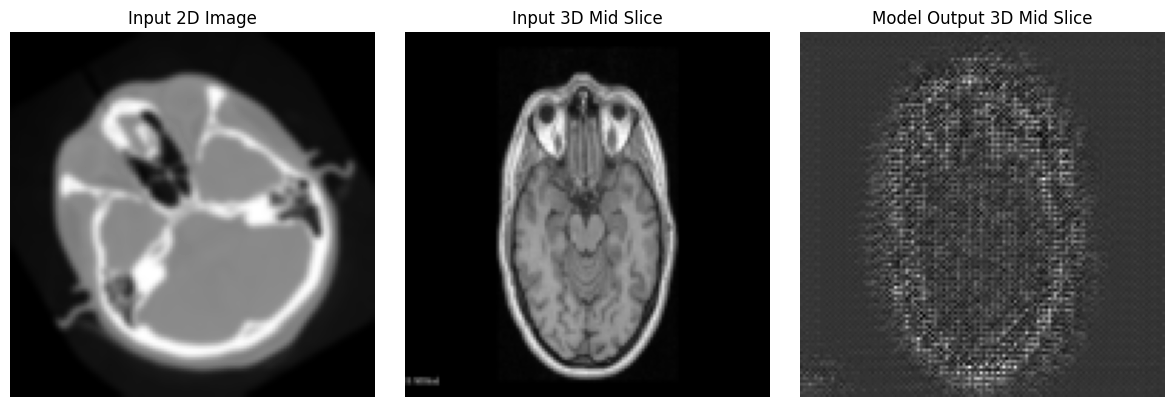

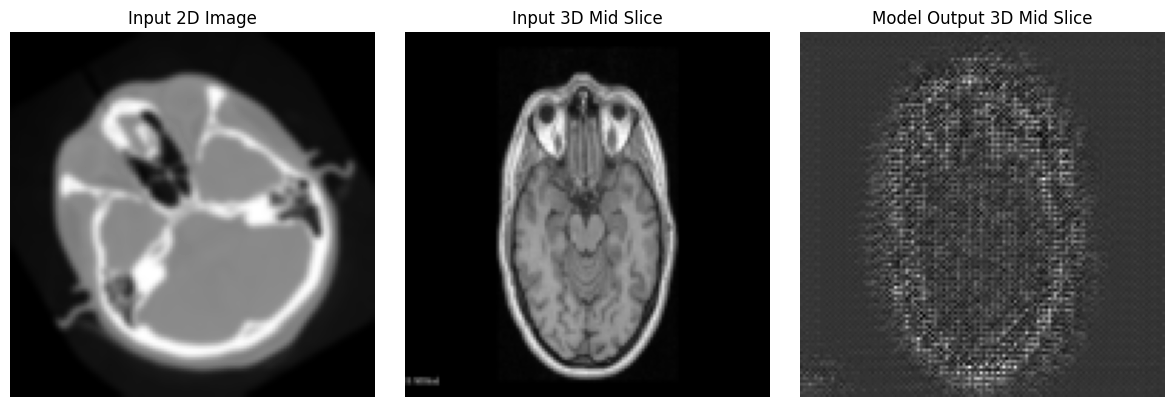

In [16]:
# Section 8: Visualization
slice_index = input_3d_np.shape[0] // 2

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input 2D Image")
plt.imshow(input_2d_np, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Input 3D Mid Slice")
plt.imshow(input_3d_np[slice_index], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Model Output 3D Mid Slice")
plt.imshow(output_3d_np[slice_index], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


# Section 8: Visualization
slice_index = input_3d_np.shape[0] // 2

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input 2D Image")
plt.imshow(input_2d_np, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Input 3D Mid Slice")
plt.imshow(input_3d_np[slice_index], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Model Output 3D Mid Slice")
plt.imshow(output_3d_np[slice_index], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

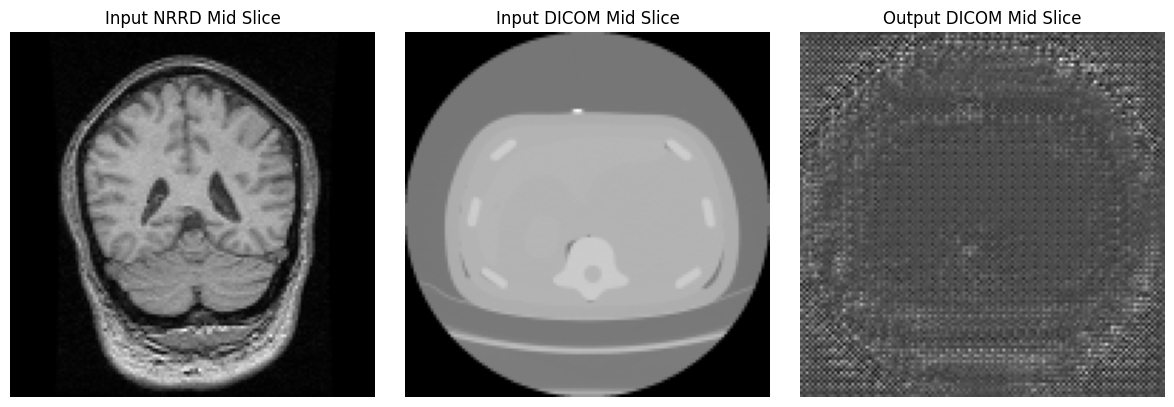

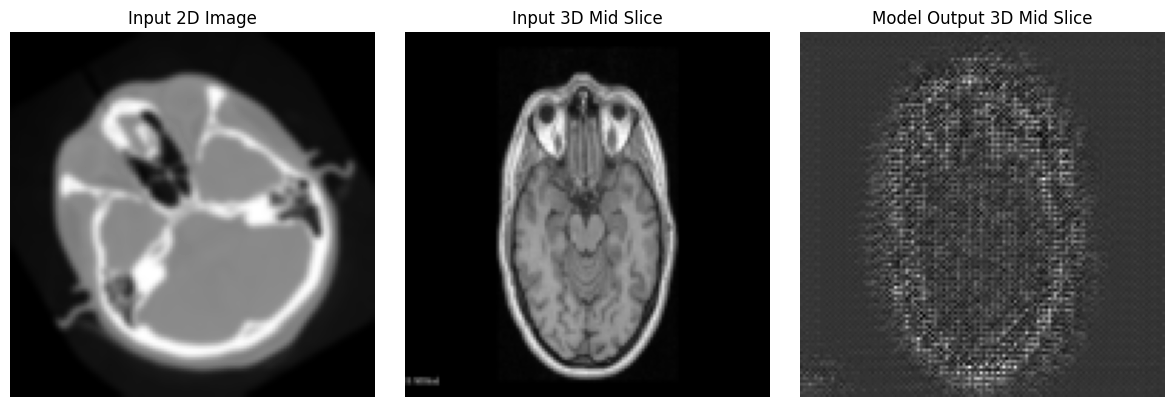

In [17]:
# Section 9: Additional Examples with NRRD and DICOM
"""
Load and run inference on additional dataset formats:
1. NRRD file (3D image)
2. DICOM series (3D image stack)
"""

def load_nrrd_file(path):
    image = sitk.ReadImage(nrrd_file_path)
    array = sitk.GetArrayFromImage(image)
    array = array.astype(np.float32)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return array

def load_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    array = sitk.GetArrayFromImage(image)
    array = array.astype(np.float32)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return array

nrrd_file_path = "D:\data\SimpleITK-Data\head_mr_oriented.mha"
dicom_folder_path = "D:\data\SimpleITK-Data\CIRS057A_MR_CT_DICOM"

image_nrrd = load_nrrd_file(nrrd_file_path)
image_dicom = load_dicom_series(dicom_folder_path)

image_nrrd_tensor = trans_3d(image_nrrd).unsqueeze(0)
image_dicom_tensor = trans_3d(image_dicom).unsqueeze(0)

with torch.no_grad():
    output_nrrd = model_3d(image_nrrd_tensor)
    output_dicom = model_3d(image_dicom_tensor)

output_nrrd_np = output_nrrd.detach().cpu().numpy()[0, 0]
output_dicom_np = output_dicom.detach().cpu().numpy()[0, 0]
input_nrrd_np = image_nrrd_tensor.detach().cpu().numpy()[0, 0]
input_dicom_np = image_dicom_tensor.detach().cpu().numpy()[0, 0]

slice_index_nrrd = input_nrrd_np.shape[0] // 2
slice_index_dicom = input_dicom_np.shape[0] // 2

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input NRRD Mid Slice")
plt.imshow(input_nrrd_np[slice_index_nrrd], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Input DICOM Mid Slice")
plt.imshow(input_dicom_np[slice_index_dicom], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Output DICOM Mid Slice")
plt.imshow(output_dicom_np[slice_index_dicom], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
slice_index = input_3d_np.shape[0] // 2

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input 2D Image")
plt.imshow(input_2d_np, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Input 3D Mid Slice")
plt.imshow(input_3d_np[slice_index], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Model Output 3D Mid Slice")
plt.imshow(output_3d_np[slice_index], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
